[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1PkOTkgiICS9SL_T1Gi1kcTbMcl6x61L8?usp=sharing)

# LSTM model - pickup predict pickup, supply predict supply

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = y_true.copy()
    epsilon = np.where(epsilon==0, np.mean(y_true), epsilon) # in case divide by 0
    mape = np.abs(y_pred - y_true) / np.abs(epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)

## <font color="yellow">[Option 1]</font> Load and preprocess data before model
Load data and pivot by each taxi vendor.

Handling missing values https://stackoverflow.com/a/52570297

I will replace NAN with "0" in "count" column

In [ ]:
%%time

nan_value = 0 # -1 or 0

def interpolate_time(taxi_subset, req_datetime, total_time_frames):
    # fix leaf out rows, merge to include all time frames, default value is nan_value
    taxi_subset.set_index(req_datetime, inplace=True)
    taxi_subset = taxi_subset.reindex(total_time_frames, fill_value = nan_value)
    # concatenate all location columns into a list
    # taxi_subset['encode_location'] = taxi_subset.loc[:, taxi_subset.columns].apply(lambda x: [i for i in x] ,axis = 1)
    return taxi_subset
    
def time_series_data_read_csv(req_datetime, req_LocationID, file_suffix, input_month):
    file_suffix = input_month + file_suffix

    taxi_agg = pd.read_csv("/content/drive/Shareddrives/Education/5709_Capstone/taxi_"+file_suffix)
    # taxi_agg.sort_values(by = ["PULocationID","PU_datetime"], axis=0, inplace=True)
    taxi_agg_pivot = taxi_agg.loc[:, [req_datetime,req_LocationID, 'count', 'taxi']]\
                            .pivot_table(index=[req_datetime, 'taxi'], columns=req_LocationID, values='count', fill_value = nan_value)\
                            .reset_index().rename_axis(None, axis = 1) # force the multi-index of column names to normal

    ########################
    # fix leaf out columns (location IDs)
    ########################
    NYLocationIDs = [i for i in range(1, 266)]
    fix_col_names = [req_datetime, 'taxi'] + NYLocationIDs # create a fixed column name list
    leafout_cols = [col for col in fix_col_names if col not in taxi_agg_pivot.columns]
    for col in leafout_cols:
        taxi_agg_pivot.insert(2, col , nan_value) # add columns with nan_value initial values

    taxi_agg_pivot = taxi_agg_pivot[fix_col_names] # reorder
    taxi_agg_pivot.columns = ["id_"+str(col) if (type(col)== int) else col for col in taxi_agg_pivot.columns] # fix numeric column name

    ########################
    # add time series columns
    ########################
    # taxi_agg_pivot['PU_datetime'] = pd.to_datetime(taxi_agg_pivot['PU_datetime'])
    # taxi_agg_pivot['weekNum'] = taxi_agg_pivot['PU_datetime'].dt.isocalendar().week
    # taxi_agg_pivot['weekday'] = taxi_agg_pivot['PU_datetime'].dt.day_name()
    # weekNum_min = taxi_agg_pivot['weekNum'].min()

    ########################
    # regress the dates to only one week, 
    # when combine with weekNum use as group,
    # plot all month in one week in x-axis
    ########################
    # weekDiff = pd.Series([pd.Timedelta(i * 7, unit = 'D') for i in (taxi_agg_pivot.weekNum - weekNum_min)])
    # taxi_agg_pivot['agg_all_in_oneWeek'] = taxi_agg_pivot['PU_datetime'] - weekDiff


    taxi_uber = taxi_agg_pivot.loc[taxi_agg_pivot.taxi == 'uber', taxi_agg_pivot.columns != 'taxi'] # leave out taxi column since we have extract a certain taxi name
    taxi_via = taxi_agg_pivot.loc[taxi_agg_pivot.taxi == 'via', taxi_agg_pivot.columns != 'taxi']
    taxi_lyft = taxi_agg_pivot.loc[taxi_agg_pivot.taxi == 'lyft', taxi_agg_pivot.columns != 'taxi']
    taxi_green = taxi_agg_pivot.loc[taxi_agg_pivot.taxi == 'green', taxi_agg_pivot.columns != 'taxi']
    taxi_yellow = taxi_agg_pivot.loc[taxi_agg_pivot.taxi == 'yellow', taxi_agg_pivot.columns != 'taxi']

    ########################
    # generate the whole month time frames
    ########################
    from_date_of_month = pd.Timestamp(2019, int(input_month), 1, 0) 
    last_day_of_month = pd.Period('2019-'+input_month+'-1').days_in_month
    to_date_of_month = pd.Timestamp(2019, int(input_month), last_day_of_month, 23, 50)
    total_time_frames = pd.date_range(from_date_of_month, to_date_of_month, freq='10min')

    taxi_via = interpolate_time(taxi_via, req_datetime, total_time_frames)
    taxi_uber = interpolate_time(taxi_uber, req_datetime, total_time_frames)
    taxi_lyft = interpolate_time(taxi_lyft, req_datetime, total_time_frames)
    taxi_green = interpolate_time(taxi_green, req_datetime, total_time_frames)
    taxi_yellow = interpolate_time(taxi_yellow, req_datetime, total_time_frames)

    return taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via



def time_series_data_read_and_append(input_months, req_datetime, req_LocationID, file_suffix_half_part):
    for i, input_month in enumerate(input_months):
        taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via = time_series_data_read_csv(req_datetime, req_LocationID, file_suffix_half_part, input_month)
        if i == 0:
            all_green, all_yellow, all_uber, all_lyft, all_via = taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via
        else:
            all_green, all_yellow, all_uber, all_lyft, all_via = (pd.concat([all_green, taxi_green]), pd.concat([all_yellow, taxi_yellow]), 
                                                           pd.concat([all_uber, taxi_uber]), pd.concat([all_lyft,taxi_lyft]),
                                                           pd.concat([all_via, taxi_via]))
            
    return all_green, all_yellow, all_uber, all_lyft, all_via


taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via = time_series_data_read_and_append(["06", "07", "08"], 'DO_datetime', 'DOLocationID', "_agg_supply.csv")
# taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via = time_series_data_read_and_append(["06", "07", "08"], 'PU_datetime', 'PULocationID', "_agg_demand.csv")


CPU times: user 14.4 s, sys: 949 ms, total: 15.4 s
Wall time: 21.3 s


In [ ]:
taxi_green.head(3)

id_1  id_2  id_3  id_4  ...  id_262  id_263  id_264  id_265
2019-06-01 00:00:00     0     0     0     0  ...       0       0       0       0
2019-06-01 00:10:00     0     0     0     0  ...       1       0       0       0
2019-06-01 00:20:00     0     0     0     0  ...       0       0       1       0

[3 rows x 265 columns]

## <font color='yellow'>[Option 2]</font> ----------- Load


In [ ]:
# proceeded_pickup = (taxi_green, taxi_yellow, taxi_uber, taxi_lyft, taxi_via)
# with open("/content/drive/Shareddrives/Education/5709_Capstone/proceeded_dropoff.pickle","wb") as f:
#     pickle.dump(proceeded_pickup, f)
with open("/content/drive/Shareddrives/Education/5709_Capstone/proceeded_pickup.pickle", "rb") as f:
    (taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand) = pickle.load(f)
with open("/content/drive/Shareddrives/Education/5709_Capstone/proceeded_dropoff.pickle", "rb") as f:
    (taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply) = pickle.load(f)

taxi_demands = [taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand]
taxi_supplies = [taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply]
taxi_names = ["green", "yellow", "uber", "lyft", "via"]

_______

## Build the model classes

- use the `ModelCheckpoint` callback to regularly save checkpoints

- the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

`classObject.load_input(taxi_subset)` ---- is for all locations as a vector input

`classObject.load_input(taxi_subset, input_column_number)` ---- is for only one column data input

`unilateral_model()` for demand inputs to predict demands, supply inputs predicting supplies.

`bilateral_model()` is demand inputs predicting supplies.

In [ ]:
import tensorflow as tf
from tensorflow import keras

input_column = 255 # for one column model
past = 7*24*6 # 7 days --> predict the 8th
train_split_ratio = 0.65
learning_rate = 0.001
batch_size = 100
nan_value = 0
n_neuron = 512

########################################################
## a week of pickup inputs predicting the Nth pickup  ##
########################################################
class unilateral_model:
    def __init__(self):
        self.x_train, self.x_val = None, None

    def load_input(self, taxi_subset, input_column=None):
        train_split = int(len(taxi_subset)*train_split_ratio)
        self.input_column = input_column
        if input_column != None:
            self.x_train, self.x_val = taxi_subset.iloc[:train_split, input_column].values, taxi_subset.iloc[train_split: -past, input_column].values
            self.y_train, self.y_val = taxi_subset.iloc[past:(train_split+past), input_column].values, taxi_subset.iloc[(train_split+past):, input_column].values
            self.multipleFeatures = False
        else:
            self.x_train, self.x_val = taxi_subset.iloc[:train_split, :].values, taxi_subset.iloc[train_split: -past, :].values
            self.y_train, self.y_val = taxi_subset.iloc[past:(train_split+past), :].values, taxi_subset.iloc[(train_split+past):, :].values
            self.multipleFeatures = True

    def batch_subsets(self, batch_size):
        self.dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                self.x_train,
                                self.y_train,
                                sequence_length=past,
                                batch_size=batch_size,
                            )
        self.dataset_val = keras.preprocessing.timeseries_dataset_from_array(
                                self.x_val,
                                self.y_val,
                                sequence_length=past,
                                batch_size=batch_size,
                            )
        
    def build_model(self, inputs, nan_value, verbose, lr, save_path):

        ###########################   TPU Start ####################################
        tf.keras.backend.clear_session()
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
        with strategy.scope():
            ##################   Keras model sequence part start  ################
            self.model = keras.models.Sequential([
                keras.layers.Masking(mask_value=nan_value,input_shape=(inputs.shape[1], inputs.shape[2] if self.multipleFeatures else 1)), # mask sequence with all NA, NA = -1
                keras.layers.LSTM(n_neuron),
                keras.layers.Dense(inputs.shape[2] if self.multipleFeatures else 1)
            ])
            ##################   Keras model sequence part end  ################

        ###########################   TPU End ####################################

        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")

        self.modelckpt_callback = keras.callbacks.ModelCheckpoint(
            monitor = "val_loss",
            filepath= save_path, 
            verbose= verbose,
            save_weights_only=True,
            save_best_only=True,
        )

    def train_model(self, epochs):
        self.history = self.model.fit(
            self.dataset_train,
            epochs=epochs,
            validation_data=self.dataset_val,
            callbacks=[self.modelckpt_callback,
                    keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
                    ],
        )

    def visualize_loss(self):
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]
        epochs = range(len(loss))
        plt.style.use('ggplot')
        plt.figure()
        plt.plot(epochs, loss, "b", label="Training loss")
        plt.plot(epochs, val_loss, "r", label="Validation loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def visualize_predict(self, taxi_name):
        count = 0
        for x_test, y_test in self.dataset_val:
            tmp = self.model.predict(x_test).round()
            if count==0:
                pred = tmp # round to integer
                target = y_test
            else:
                pred = np.append(pred, tmp, axis = 0)
                target = np.append(target, y_test, axis = 0)
            count += 1

        timeframe = range(target.shape[0])
        plt.style.use('ggplot')
        if self.multipleFeatures:
            for column_num in [6, 254, 242,230]:
                plt.figure(figsize=(18, 4))
                plt.plot(timeframe, target[:, column_num], "royalblue", label="Target")
                plt.plot(timeframe, pred[:, column_num], "tomato", label="Predicted")
                plt.title("Prediction vs Truth at location "+str(column_num+1)+" over time for "+taxi_name)
                plt.xlabel("Time frames")
                plt.ylabel("Taxi amount")
                plt.legend()
                plt.show()
        else:
            plt.figure(figsize=(18, 4))
            plt.plot(timeframe, target, "royalblue", label="Target")
            plt.plot(timeframe, pred, "tomato", label="Predicted")
            plt.title("Prediction vs Truth at location "+str(self.input_column+1)+" over time")
            plt.xlabel("Time frames")
            plt.ylabel("Taxi amount")
            plt.legend()
            plt.show()
        return pred, target

########################################################
## a week of pickup inputs predicting the Nth dropoff ##
########################################################
class bilateral_model(unilateral_model):
    def __init__(self):
        super().__init__()
        self.x_train, self.x_val = None, None

    def load_input(self, demand_subset, supply_subset):
        train_split = int(len(demand_subset)*0.6)
        self.x_train, self.x_val = demand_subset.iloc[:train_split, :].values, demand_subset.iloc[train_split:, :].values
        self.y_train, self.y_val = supply_subset.iloc[:train_split, :].values, supply_subset.iloc[train_split:, :].values
        self.multipleFeatures = True

In [ ]:
# build a model just to indicate the summary
pickup_uber = unilateral_model()
pickup_uber.load_input(taxi_via_demand)
pickup_uber.batch_subsets(batch_size) # batch_size
for batch in pickup_uber.dataset_val.take(1):
    x_val, y_val = batch
pickup_uber.build_model(x_val, # input.shape is the sequential length (past, 1)
                        nan_value, 0, # verbose
                        learning_rate, 
                        "uni_model_checkpoint.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 1008, 265)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1593344   
_________________________________________________________________
dense (Dense)                (None, 265)               135945    
Total params: 1,729,289
Trainable params: 1,729,289
Non-trainable params: 0
_________________________________________________________________
None


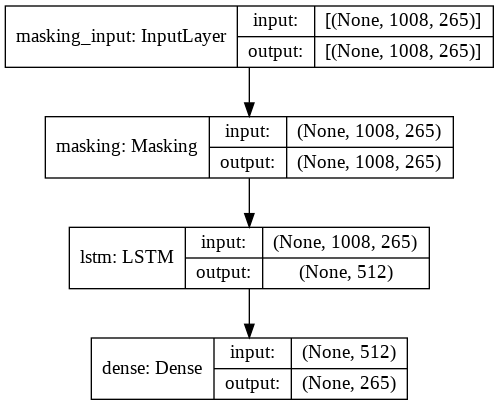

In [ ]:
from keras.utils import plot_model
plot_model(pickup_uber.model, to_file='LSTM_model.png', show_shapes=True,show_layer_names=True)

print(pickup_uber.model.summary())

from IPython.display import Image 
Image('LSTM_model.png')

## Train

#### Load weights to boost up training

In [ ]:
# initial_weights_uni = pickup_uber.model.get_weights()
# with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/pickup_InitialWeights_AllCols.pickle","wb") as f:
#     pickle.dump(initial_weights_uni, f)
with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/pickup_InitialWeights_AllCols.pickle","rb") as f:
    initial_weights_uni = pickle.load(f)
pickup_uber = unilateral_model()



#### <font color='yellow'>All columns at a time</font>

The model that accepts inputs of multiple locations does not perform well on certain area taxi demand/supply may surge rapidly during rush hours. This model tends to average the amounts with other locations.

##### <font color="yellow">[Option 1]</font> Train for pickup - pickup , dropoff-dropoff

Use a week of pickup demands as inputs, output target is the N-th time step's pickup demand.

INFO:tensorflow:Initializing the TPU system: grpc://10.75.121.42:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Wor

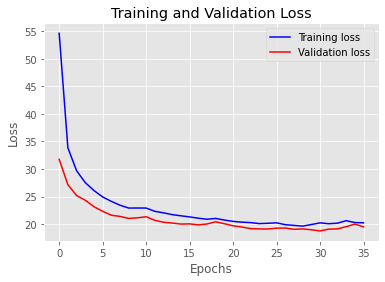

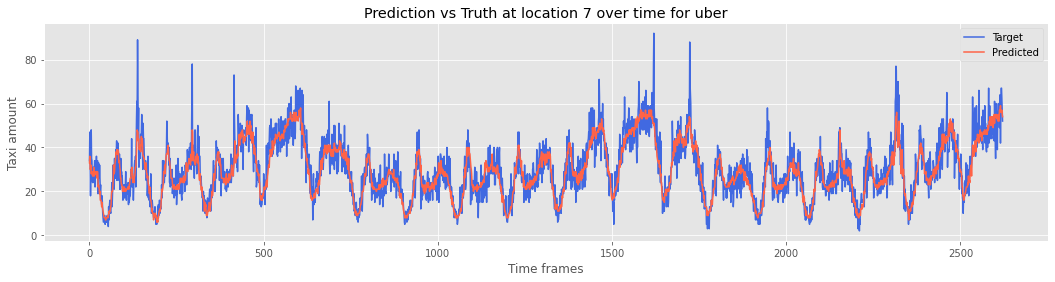

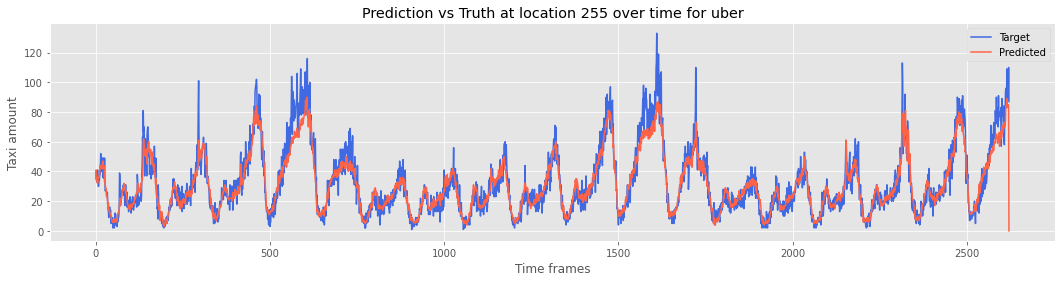

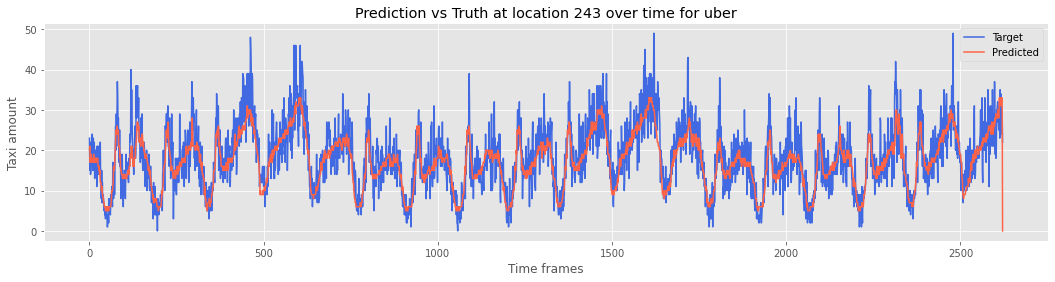

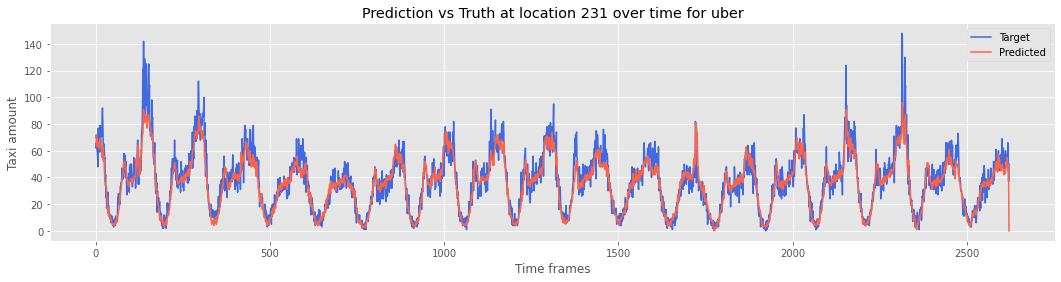

INFO:tensorflow:Initializing the TPU system: grpc://10.75.121.42:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Wor

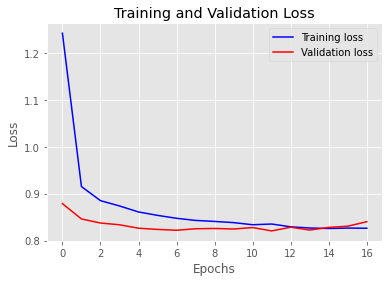

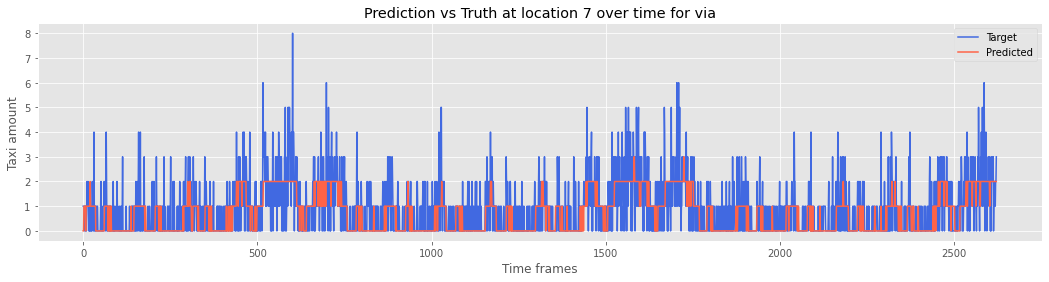

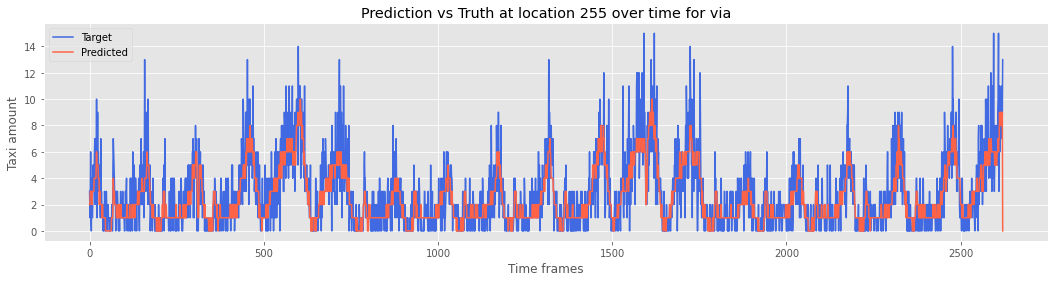

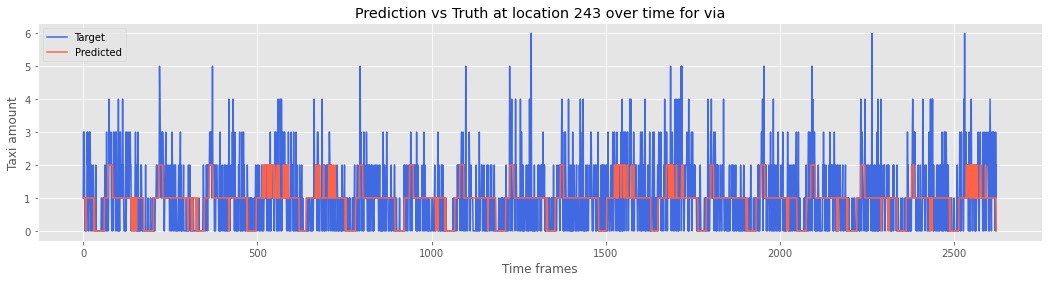

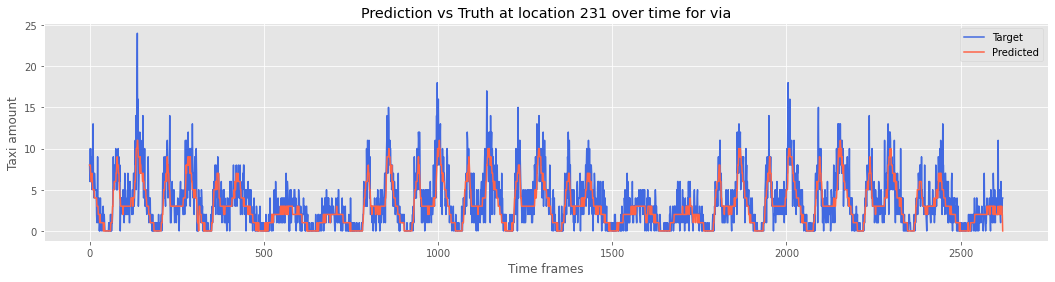

INFO:tensorflow:Initializing the TPU system: grpc://10.75.121.42:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Wor

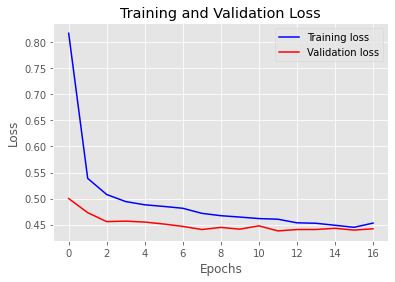

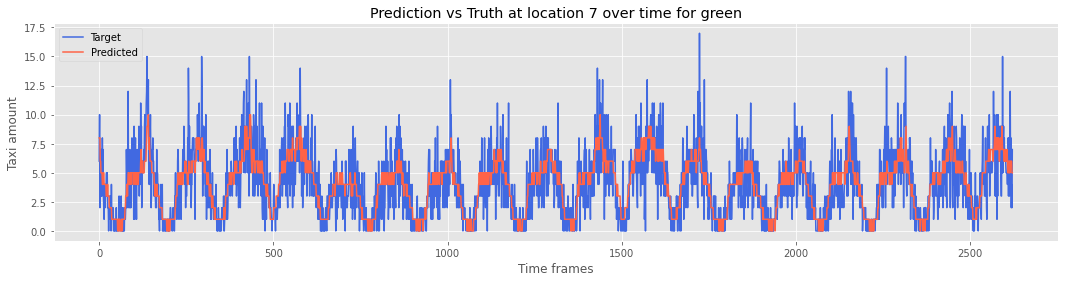

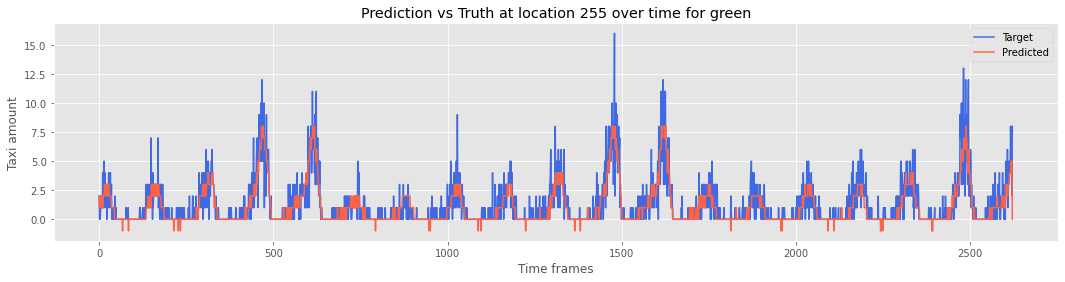

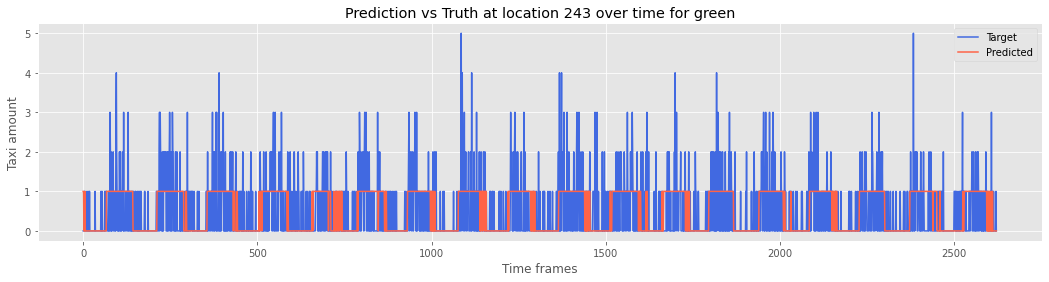

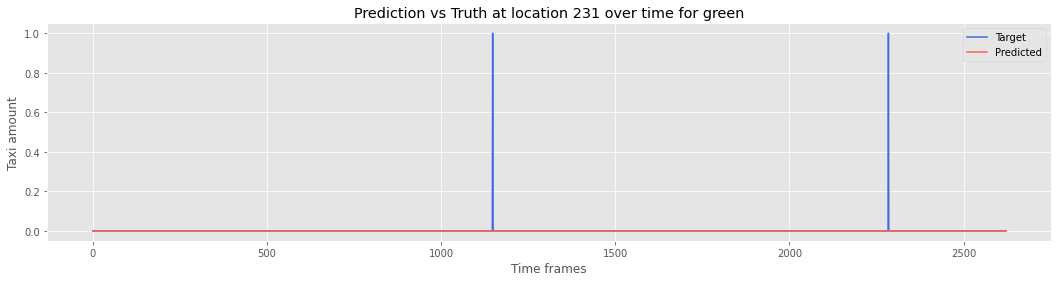

INFO:tensorflow:Initializing the TPU system: grpc://10.75.121.42:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Wor

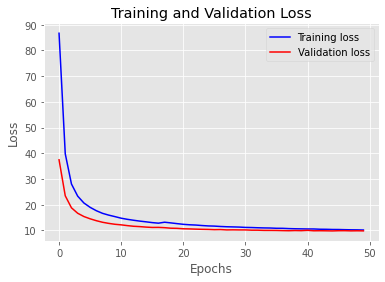

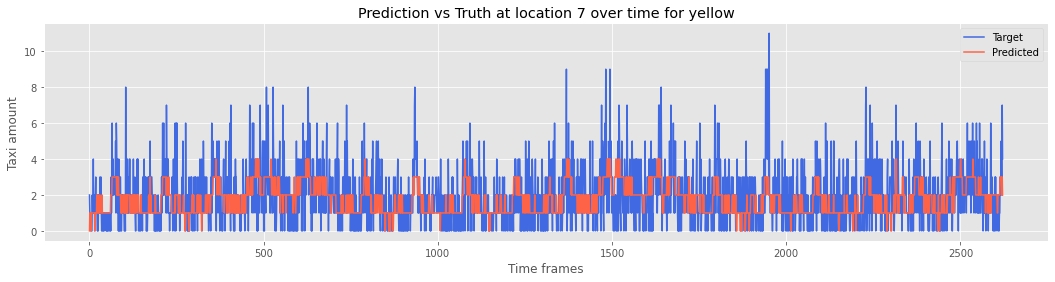

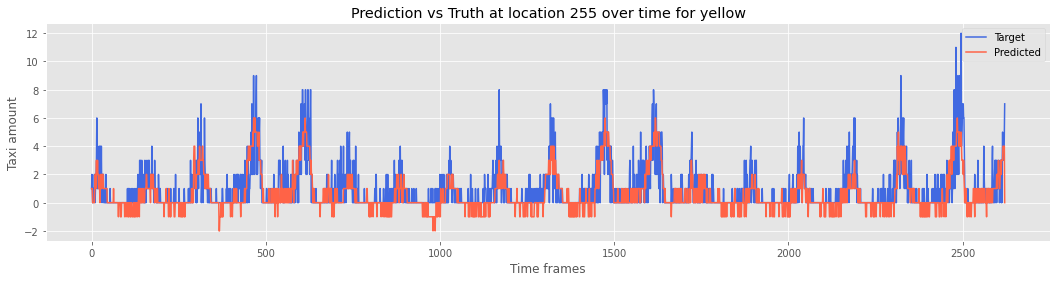

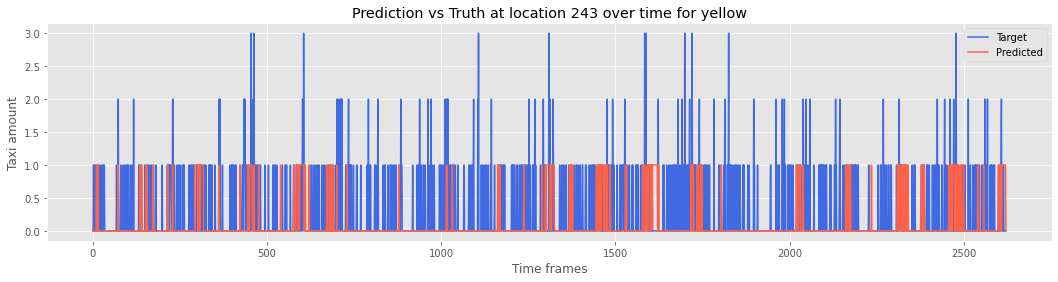

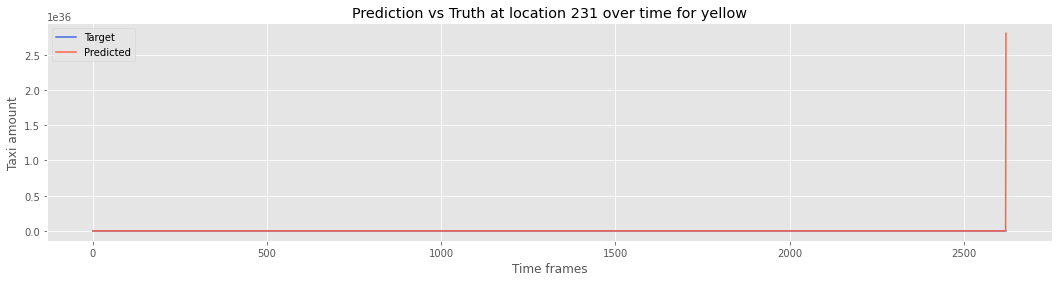

CPU times: user 5min 15s, sys: 30.1 s, total: 5min 45s
Wall time: 47min 11s


In [ ]:
%%time

def trainSave_all_location_models(taxi_subset, subset_name, pickup_dropoff):
    pickup_uber.load_input(taxi_subset)
    pickup_uber.batch_subsets(batch_size) # batch_size
    save_checkpoint_file = "/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/" + pickup_dropoff + "_" + subset_name + "_06-08_AllCols.h5"
    for batch in pickup_uber.dataset_train.take(1):
        inputs, targets = batch
    pickup_uber.build_model(inputs, # input.shape is the sequential length (past, 1)
                            nan_value, 0, # verbose
                            learning_rate, 
                            save_checkpoint_file)
    # initialize the weights to boost up the training
    pickup_uber.model.set_weights(initial_weights_uni)
    pickup_uber.train_model(300) # epochs
    pickup_uber.visualize_loss()
    _, _ = pickup_uber.visualize_predict(subset_name)

pickup_dropoff = "pickup"
trainSave_all_location_models(taxi_uber_demand, "uber", pickup_dropoff)
# trainSave_all_location_models(taxi_lyft_demand, "lyft", pickup_dropoff)
trainSave_all_location_models(taxi_via_demand, "via",pickup_dropoff)
trainSave_all_location_models(taxi_green_demand, "green", pickup_dropoff)
trainSave_all_location_models(taxi_yellow_demand, "yellow",pickup_dropoff)

# pickup_dropoff = "dropoff"
# trainSave_all_location_models(taxi_uber_supply, "uber", pickup_dropoff)
# trainSave_all_location_models(taxi_lyft_supply, "lyft", pickup_dropoff)
# trainSave_all_location_models(taxi_via_supply, "via",pickup_dropoff)
# trainSave_all_location_models(taxi_green_supply, "green", pickup_dropoff)
# trainSave_all_location_models(taxi_yellow_supply, "yellow",pickup_dropoff)

##### <font color="yellow">[Option 2]</font> Train for pickup - dropoff

Use a week of pickup demands as inputs, output target is the N-th time step's drop demand.

In [ ]:
%%time

def trainSave_all_location_models(demand_subset, supply_subset, subset_name, pickup_dropoff):
    pu_do_uber.load_input(demand_subset, supply_subset)
    pu_do_uber.batch_subsets(batch_size) # batch_size
    save_checkpoint_file = "/content/gdrive/Shareddrives/Education/5709_Capstone/" + pickup_dropoff + "_" + subset_name + "_06-08_AllCols.h5"
    for batch in pu_do_uber.dataset_train.take(1):
        inputs, targets = batch
    pu_do_uber.build_model(inputs, # input.shape is the sequential length (past, 1)
                            nan_value, 0, # verbose
                            learning_rate, 
                            save_checkpoint_file)
    # initialize the weights to boost up the training
    pu_do_uber.model.set_weights(initial_weights_bi)
    pu_do_uber.train_model(100) # epochs
    _, _ = pu_do_uber.visualize_predict(subset_name)

# trainSave_all_location_models(taxi_uber_demand, taxi_uber_supply, "uber", "pu-do")
trainSave_all_location_models(taxi_lyft_demand, taxi_lyft_supply, "lyft", "pu-do")
# trainSave_all_location_models(taxi_via_demand, taxi_via_supply, "via", "pu-do")
# trainSave_all_location_models(taxi_green_demand, taxi_green_supply, "green", "pu-do")
# trainSave_all_location_models(taxi_yellow_demand, taxi_yellow_supply, "yellow", "pu-do")

# Prediction on the future

We take a week's record to predict the next one time frame. Let $[x_0, x_1, ..., x_n]$ denote the time spectrum of a week, $N=6*24*7$ for a 10min window period, with $[x_0, x_1, ..., x_n]$ we can predict the $x_{n+1}$. 

##  <font color="yellow">[Option 1]</font> Evaluate and save (Pickup - pickup, pickup - dropoff)

Then we take the average of $x_{n+1}'$ with the true target value $x_{n+1}$, denote the new value as $\mathbf{x}_{n+1}=\frac{x_{n+1}'+x_{n+1}}{2}$. We use this new value as input $[x_1, ..., x_n, \mathbf{x}_{n+1}]$ to predict the next time frame $x_{n+2}$. 

Repeat the above logic until we acquire a whole week of prediction.

In [ ]:
########################################################
#### Build models of pickup-pickup and pickup-drop #####
########################################################
def predict_pickup_dropoff_save(demand_subset, supply_subset, taxi_name):
    '''
    we need to predict two weeks of pickup to finally obtain
    the enough inputs for forecasting a weeks of dropoff
    '''
    ########################## predict two weeks of pickups based on pickups #####################################
    pickup_uber = unilateral_model()
    pickup_uber.load_input(demand_subset)
    pickup_uber.batch_subsets(batch_size) # batch_size
    for batch in pickup_uber.dataset_val.take(1):
        x_val, y_val = batch
    pickup_uber.build_model(x_val, # input.shape is the sequential length (past, 1)
                            nan_value, 0, # verbose
                            learning_rate, 
                            "uni_model_checkpoint.h5") # this path will not take effect since we are not fitting the model.
    pickup_uber.model.load_weights("/content/drive/Shareddrives/Education/5709_Capstone/pickup_"+taxi_name+"_06-08_AllCols.h5")
    for j in range(2):
        x0_xn = tf.reshape(x_val[j], [1, x_val[j].shape[0], x_val[j].shape[1]]) # (1, 1008, 265), input of the model should be this one
        y_true = x_val[j+1].numpy() # (1008, 265)
        for i in range(x0_xn.shape[1]):
            y_pred_n1 = pickup_uber.model.predict(x0_xn).round() # (1, 265)
            y_pred_n1 = np.mean([y_pred_n1, y_true[i].reshape(1, -1)], axis=0) # (1, 265)
            x1_xn1 = np.append(x0_xn[:, 1:, :], y_pred_n1.reshape((1, 1, -1)), axis = 1)
            x0_xn = x1_xn1
            if i==0 and j==0:
                y_pred_record = y_pred_n1.reshape((1,-1))
            else:
                y_pred_record = np.append(y_pred_record, y_pred_n1.reshape((1,-1)), axis = 0) # final output y_pred_record (1008 x 2, 265)
    # timeframe = range(x0_xn.shape[1])
    # for column_num in [6, 254, 242,230]:
    #     plt.figure(figsize=(18, 4))
    #     plt.plot(timeframe, y_true[:, column_num], "royalblue", label="Target")
    #     plt.plot(timeframe, y_pred_record[0, :, column_num], "tomato", label="Predicted")
    #     plt.title("Demand prediction vs truth at location "+str(column_num+1)+" over time for uber")
    #     plt.xlabel("Time frames")
    #     plt.ylabel("Taxi amount")
    #     plt.legend()
    #     plt.show()
    with open("/content/drive/Shareddrives/Education/5709_Capstone/uni_model_pickup_prediction_2_weeks_"+taxi_name+".pkl", "wb") as f:
        pickle.dump(y_pred_record, f)

    ################### predict one week of dropoff based on two weeks of predicted pickups ####################
    pu_do_uber = bilateral_model()
    pu_do_uber.load_input(demand_subset, supply_subset)
    pu_do_uber.batch_subsets(batch_size) # batch_size
    for batch in pu_do_uber.dataset_train.take(1):
        x_train, y_train = batch
    pu_do_uber.build_model(x_train, # input.shape is the sequential length (past, 1)
                            nan_value, 0, # verbose
                            learning_rate, 
                            "bi_model_checkpoint.h5")
    pu_do_uber.model.load_weights("/content/drive/Shareddrives/Education/5709_Capstone/pu-do_"+taxi_name+"_06-08_AllCols.h5")
    for i in range(1008): # a week
        tmp = pu_do_uber.model.predict(y_pred_record[i:i+1008, :].reshape((1, 1008, 265))).round() # (1, 265)
        if i==0:
            dropoff_pred = tmp
        else:
            dropoff_pred = np.append(dropoff_pred, tmp, axis=0)
    # supply_true = taxi_uber_supply.iloc[1008]
    # locations = range(len(supply_true))
    # plt.figure(figsize=(30, 4))
    # plt.plot(locations, supply_true, "royalblue", label="Target")
    # plt.plot(locations, dropoff_pred.flatten(), "tomato", label="Predicted")
    # plt.title("Supplies predicted from predicted demands vs truth at all locations for uber")
    # plt.xlabel("Locations")
    # plt.ylabel("Taxi amount")
    # plt.legend()
    # plt.show()
    with open("/content/drive/Shareddrives/Education/5709_Capstone/bi_model_pickup_predict_one_week_dropoff_"+taxi_name+".pkl", "wb") as f:
        pickle.dump(dropoff_pred, f)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 14.8 µs


In [ ]:
%%time
predict_pickup_dropoff_save(taxi_lyft_demand, taxi_lyft_supply, "lyft")
predict_pickup_dropoff_save(taxi_via_demand, taxi_via_supply, "via")
predict_pickup_dropoff_save(taxi_green_demand, taxi_green_supply, "green")
predict_pickup_dropoff_save(taxi_yellow_demand, taxi_yellow_supply, "yellow")
predict_pickup_dropoff_save(taxi_uber_demand, taxi_uber_supply, "uber")

##  <font color="yellow">[Option 2]</font> Evaluate and save (Pickup - pickup, dropoff - dropoff)

Record the mean square error.

In [ ]:
########################################################
####    Build a model, load weights, and predict   #####
########################################################
def predict_pickup_dropoff_save(demand_subset, taxi_name, pickup_dropoff):
    pickup_uber = unilateral_model()
    pickup_uber.load_input(demand_subset)
    pickup_uber.batch_subsets(batch_size) # batch_size
    for batch in pickup_uber.dataset_val.take(1):
        x_val, y_val = batch
    pickup_uber.build_model(x_val, # input.shape is the sequential length (past, 1)
                            nan_value, 0, # verbose
                            learning_rate, 
                            "uni_model_checkpoint.h5") # this path will not take effect since we are not fitting the model.
    pickup_uber.model.load_weights("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/"+pickup_dropoff+"_"+taxi_name+"_06-08_AllCols.h5")
    y_preds, y_true = [], []
    for x_val, y_val in pickup_uber.dataset_val.take(int(1008/100)+1): # predict for only one week, if using full validation data, the last one row is always exploding
        y_pred = pickup_uber.model.predict(x_val)
        if y_preds == []:
            y_preds = y_pred
            y_true = y_val
        else:
            y_preds = np.append(y_preds, y_pred, axis=0)
            y_true = np.append(y_true, y_val, axis=0)

    feature = 'demand' if pickup_dropoff =="pickup" else 'supply'
    model_MSE.loc[(taxi_name, feature), 'MAPE'] = mean_absolute_percentage_error(y_true, y_preds)
    model_MSE.loc[(taxi_name, feature), 'R2'] = r2_score(y_true, y_preds)
    model_MSE.loc[(taxi_name, feature), 'MSE'] = mean_squared_error(y_true, y_preds)

    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/"+pickup_dropoff+"_prediction_"+taxi_name+".pkl", "wb") as f:
        pickle.dump((y_preds, y_true), f)

########################################################
####                  Evaluation                   #####
########################################################
multiIndex = pd.MultiIndex.from_product([taxi_names, ['demand', 'supply']], names=["vendor", "feature"])
model_MSE = pd.DataFrame(index=multiIndex, columns = ['MAPE','R2','MSE'])

for i, taxi_name in enumerate(taxi_names):
    predict_pickup_dropoff_save(taxi_demands[i], taxi_name, 'pickup')
    predict_pickup_dropoff_save(taxi_supplies[i], taxi_name, 'dropoff')


In [ ]:
model_MSE.to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/prediction_Evaluation_matrices.csv")
model_MSE

MAPE         R2       MSE
vendor feature                               
green  demand   0.407439  -0.548636  0.419484
       supply   0.554495  0.0418831   0.39146
yellow demand   0.164003  -0.651016   9.67035
       supply   0.244723  0.0885369   8.13781
uber   demand   0.352809   0.509916   18.8946
       supply   0.350481   0.554654   17.1776
lyft   demand     0.4027    0.20723   5.09857
       supply    0.39234   0.262903   4.80705
via    demand   0.292232  -0.125982  0.807998
       supply   0.295378 -0.0501795  0.846741

In [ ]:
# old method, 2 weeks of pickup - predicting 1 week of dropoff
pd.read_csv("/content/drive/Shareddrives/Education/5709_Capstone/prediction_Evaluation_matrices.csv", index_col=[0,1])

MAPE        R2        MSE
vendor feature                               
green  demand   0.260061 -0.328220   0.646256
       supply   0.384930 -0.025446   0.543909
yellow demand   0.190058 -0.274726  20.360519
       supply   0.336362 -0.057923  33.037414
uber   demand   0.437374  0.406965  35.845742
       supply   0.483399  0.391337  59.927598
lyft   demand   0.422129  0.168021   8.398393
       supply   0.411408  0.224303   9.962878
via    demand   0.253442 -0.019907   1.220762
       supply   0.283524 -3.225024   1.537500

## After the predicting process, <font color='yellow'>load</font> and plot

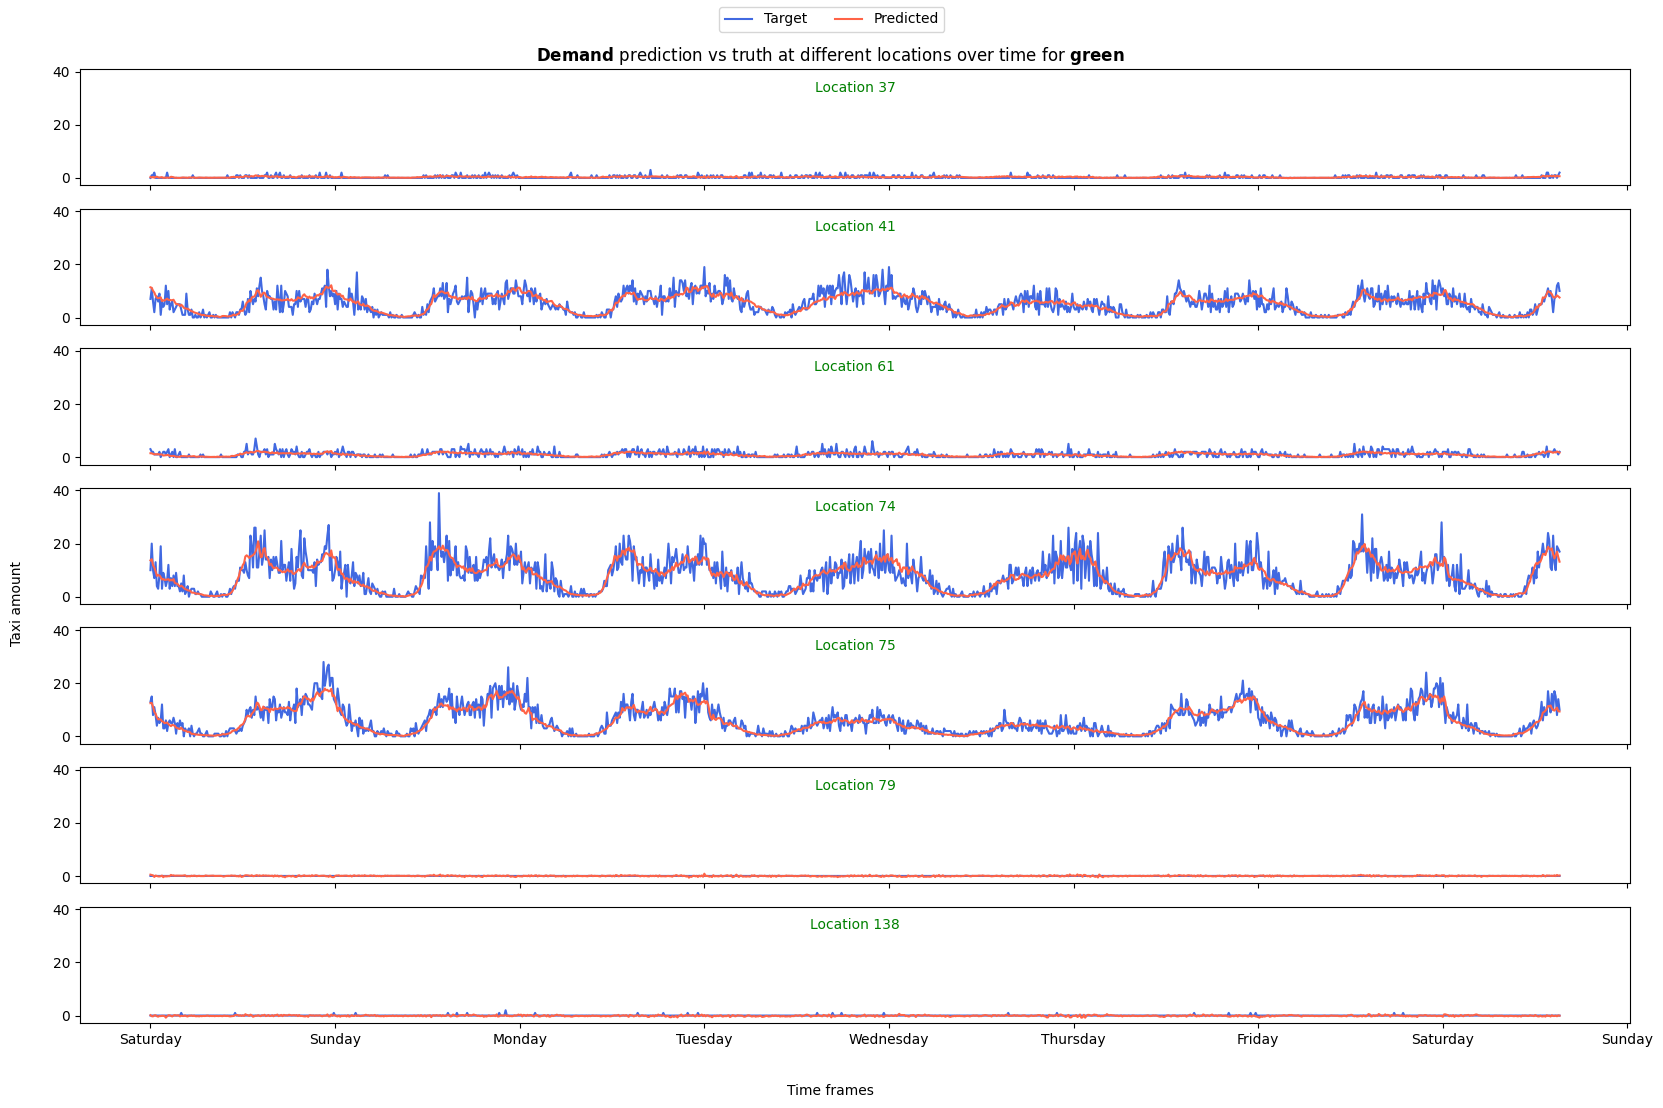

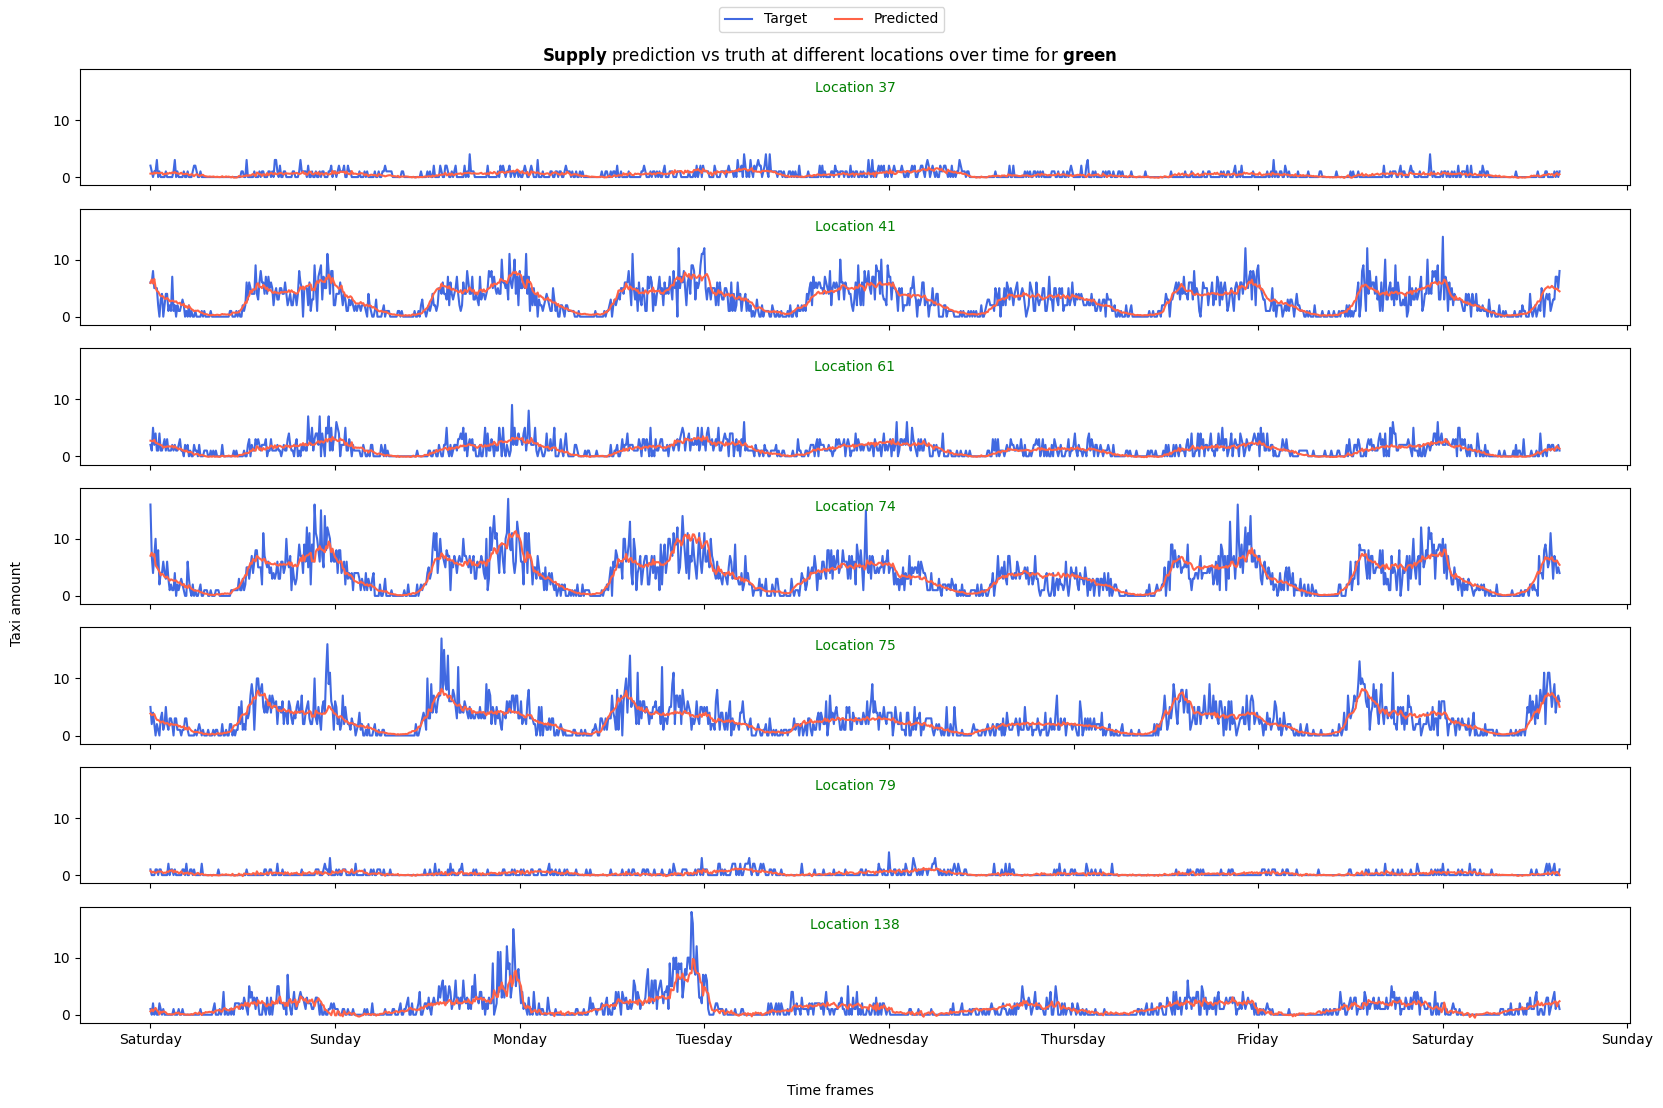

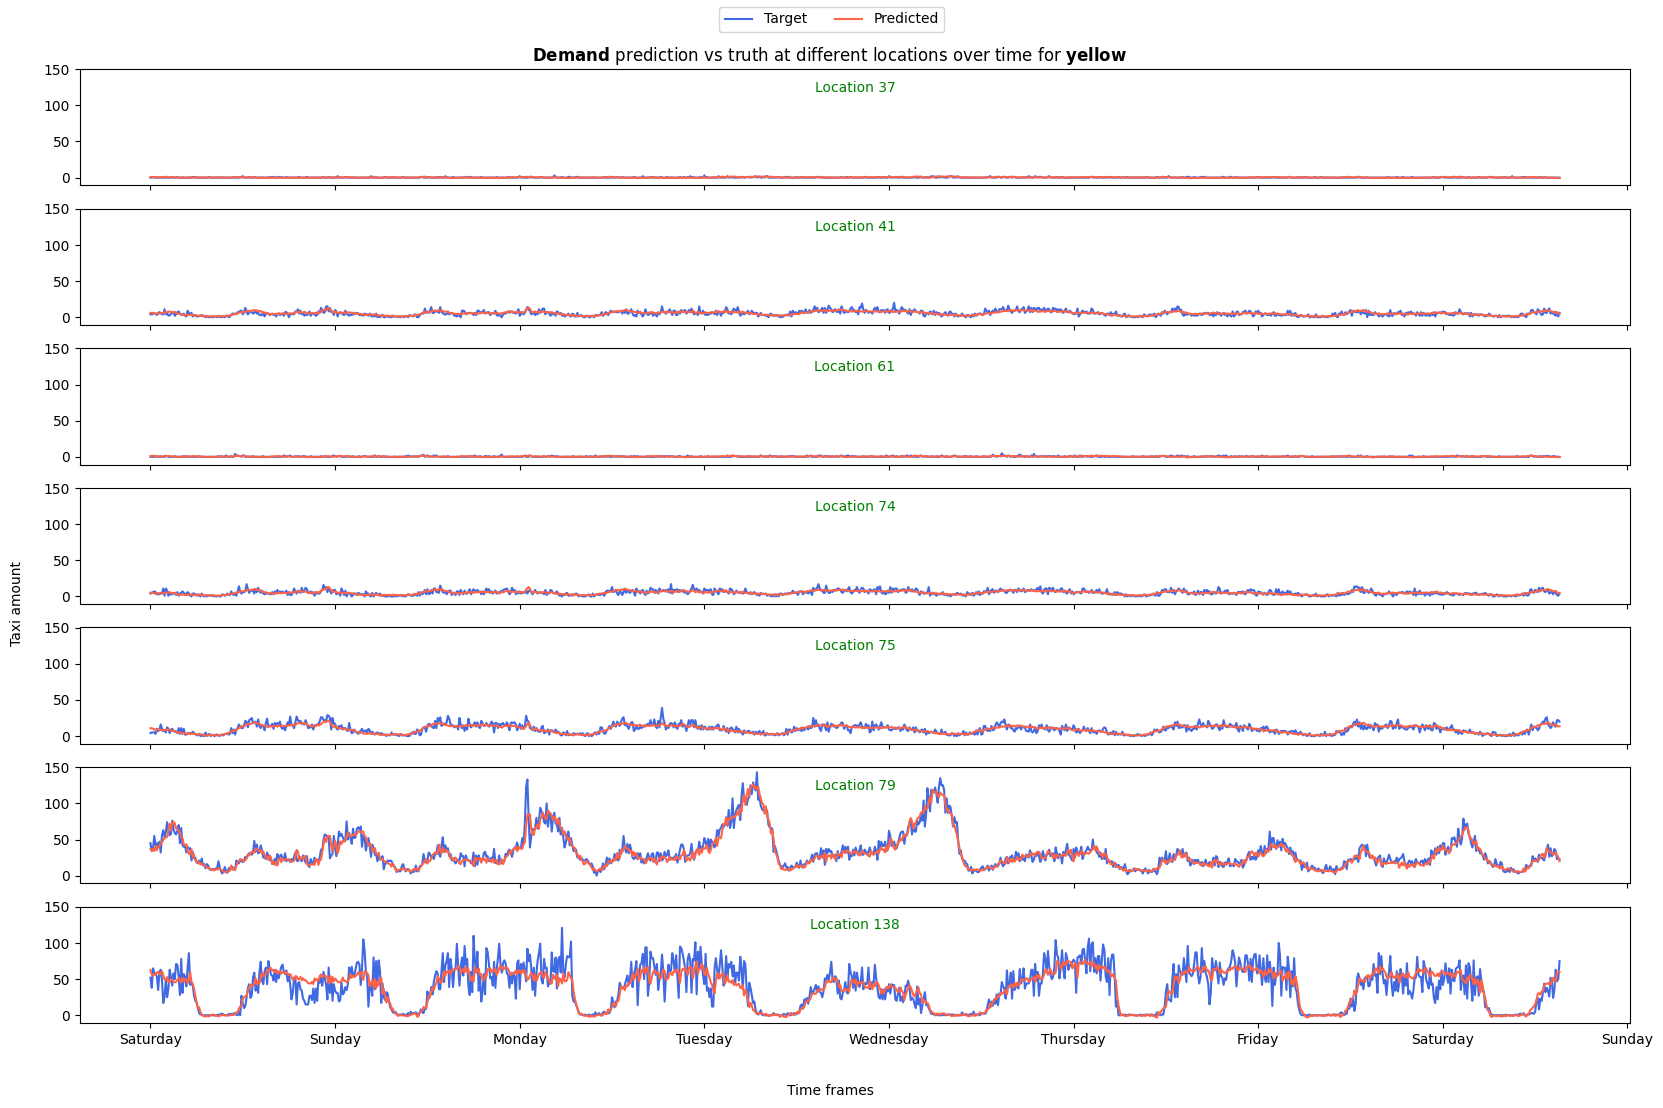

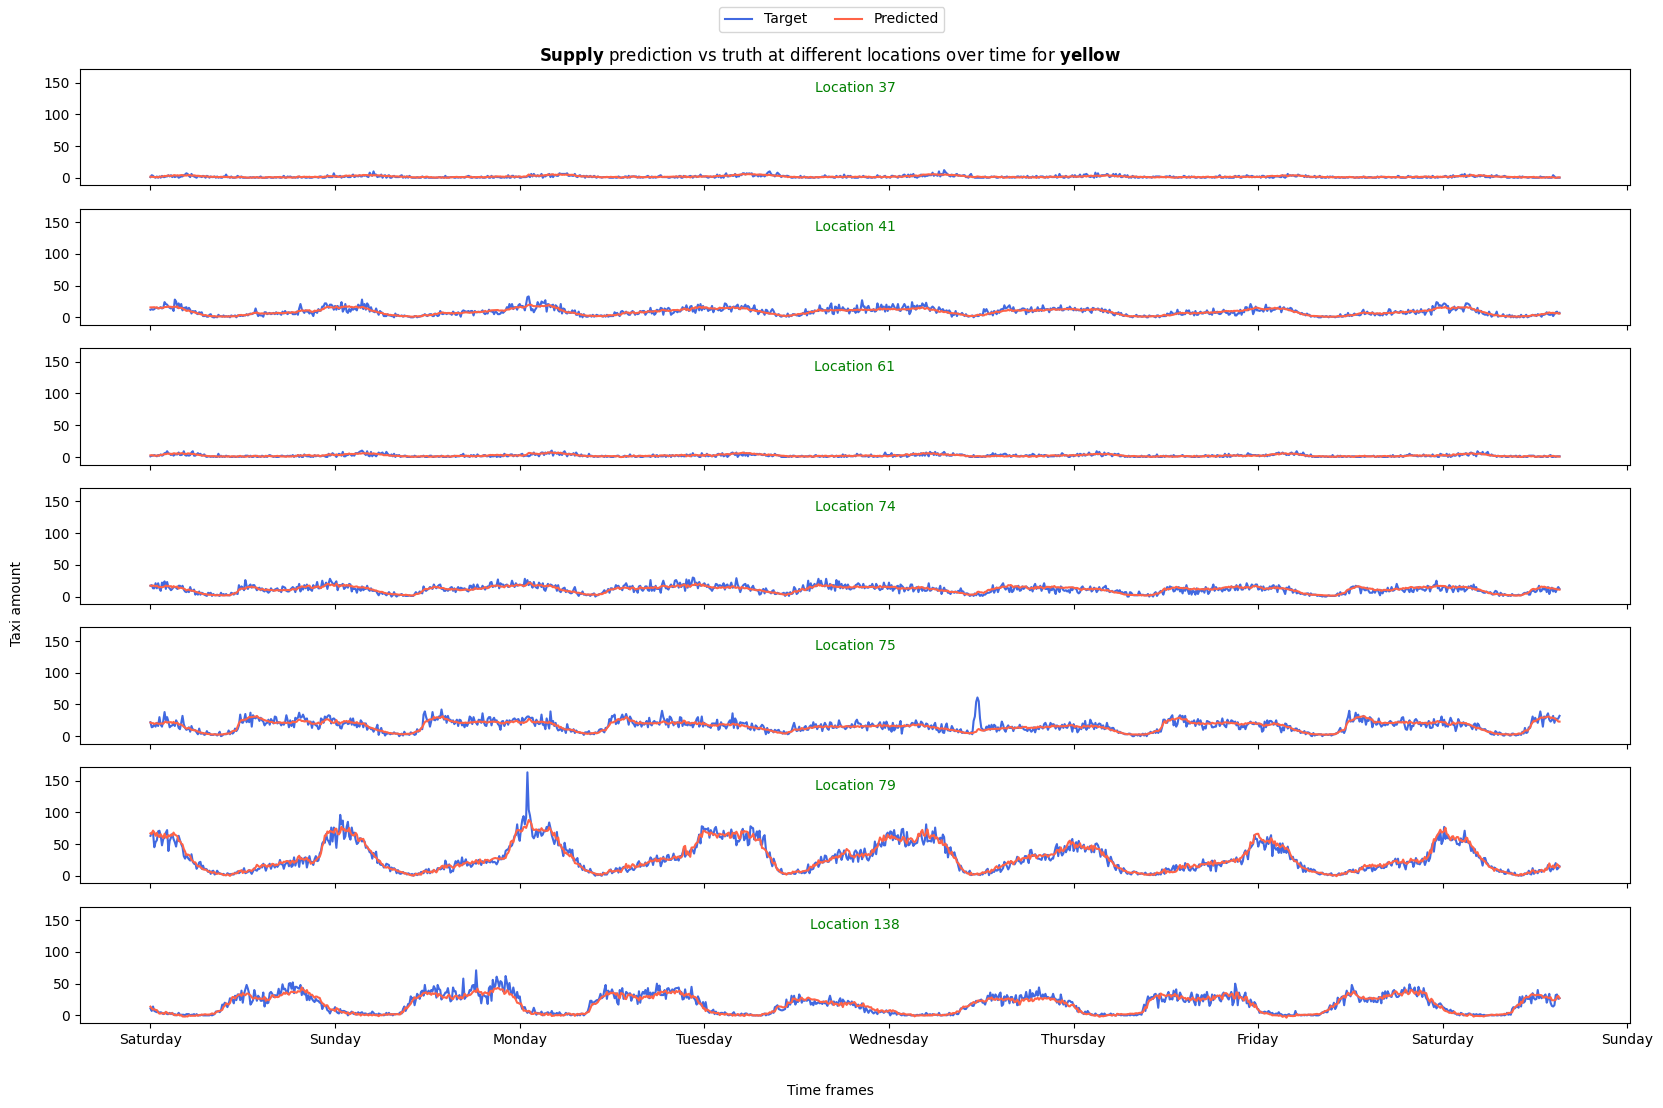

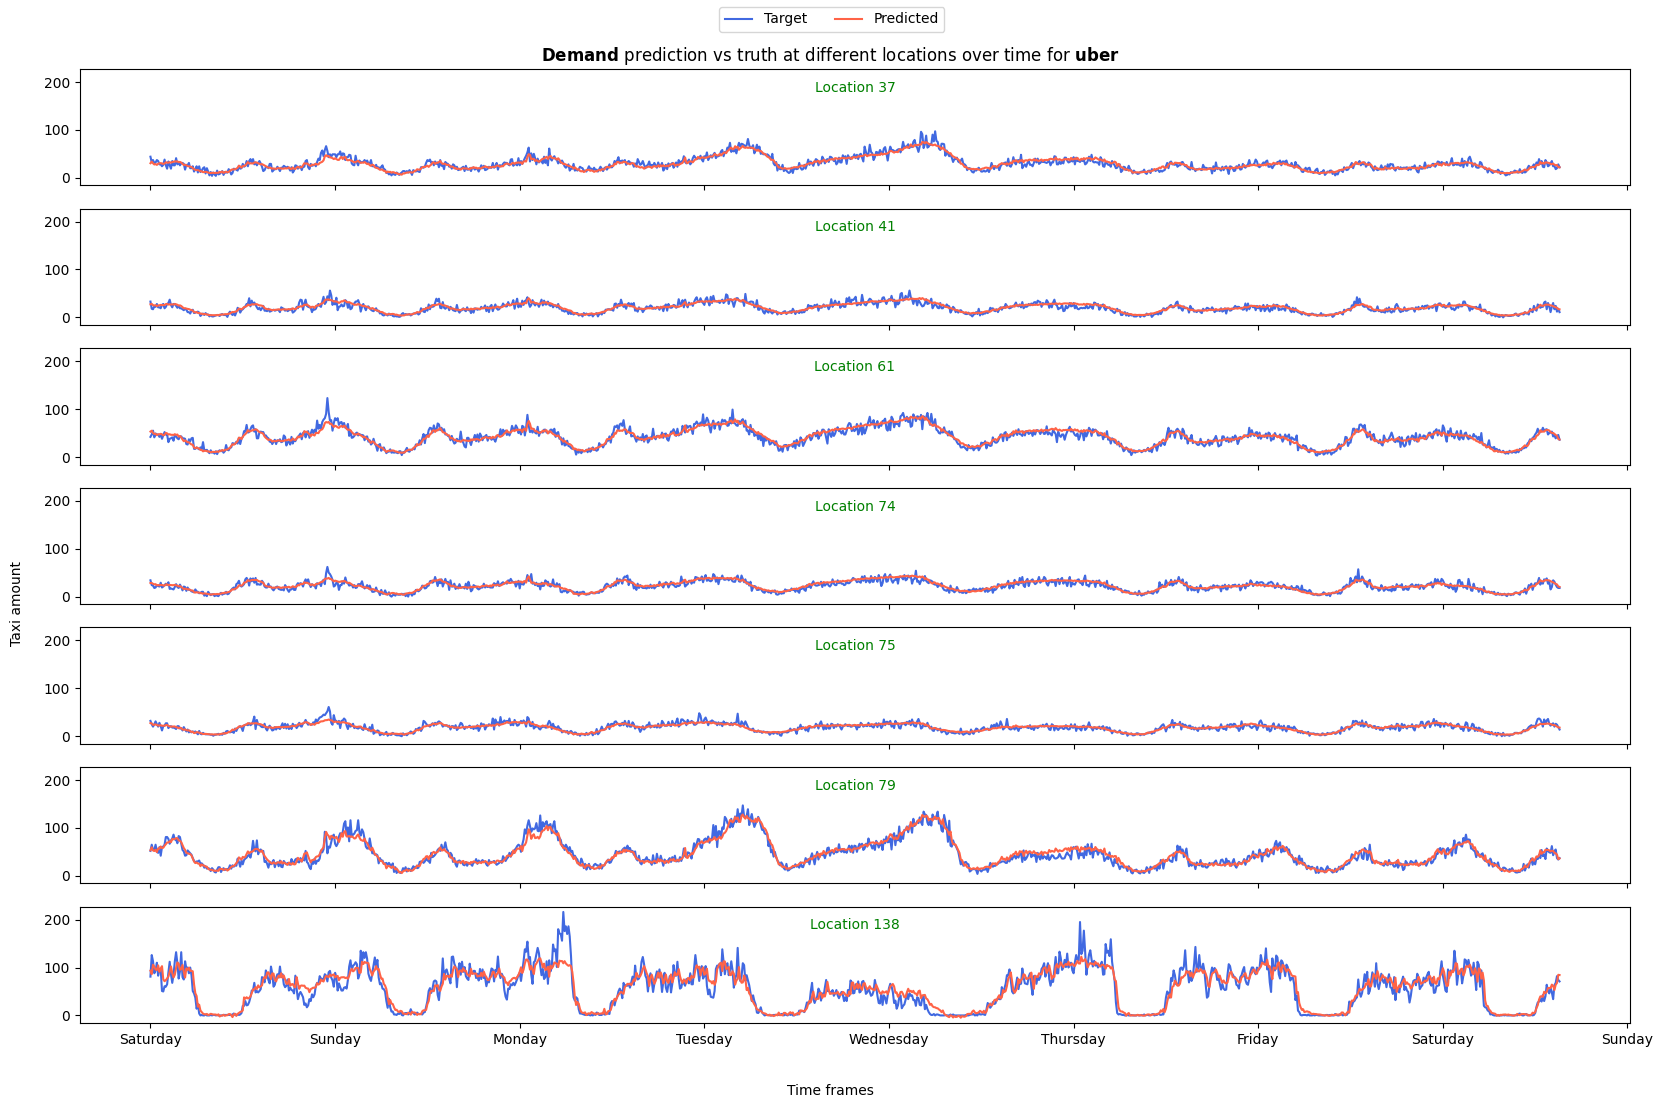

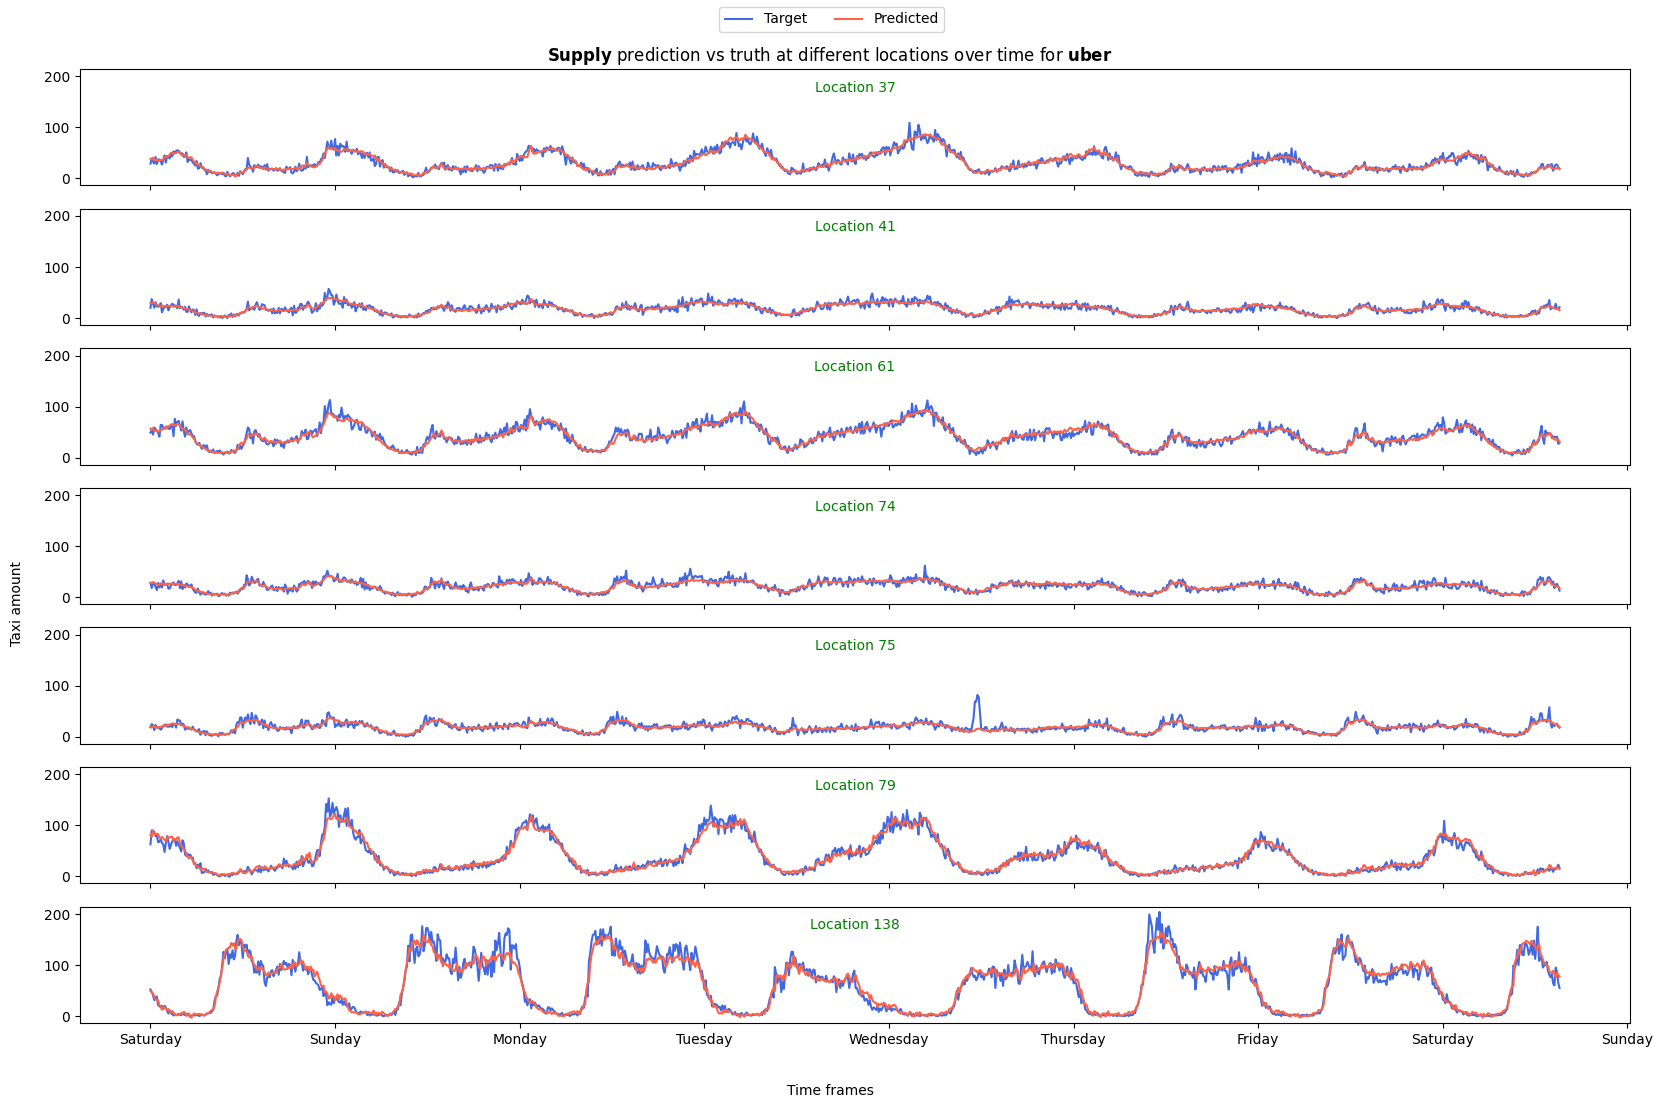

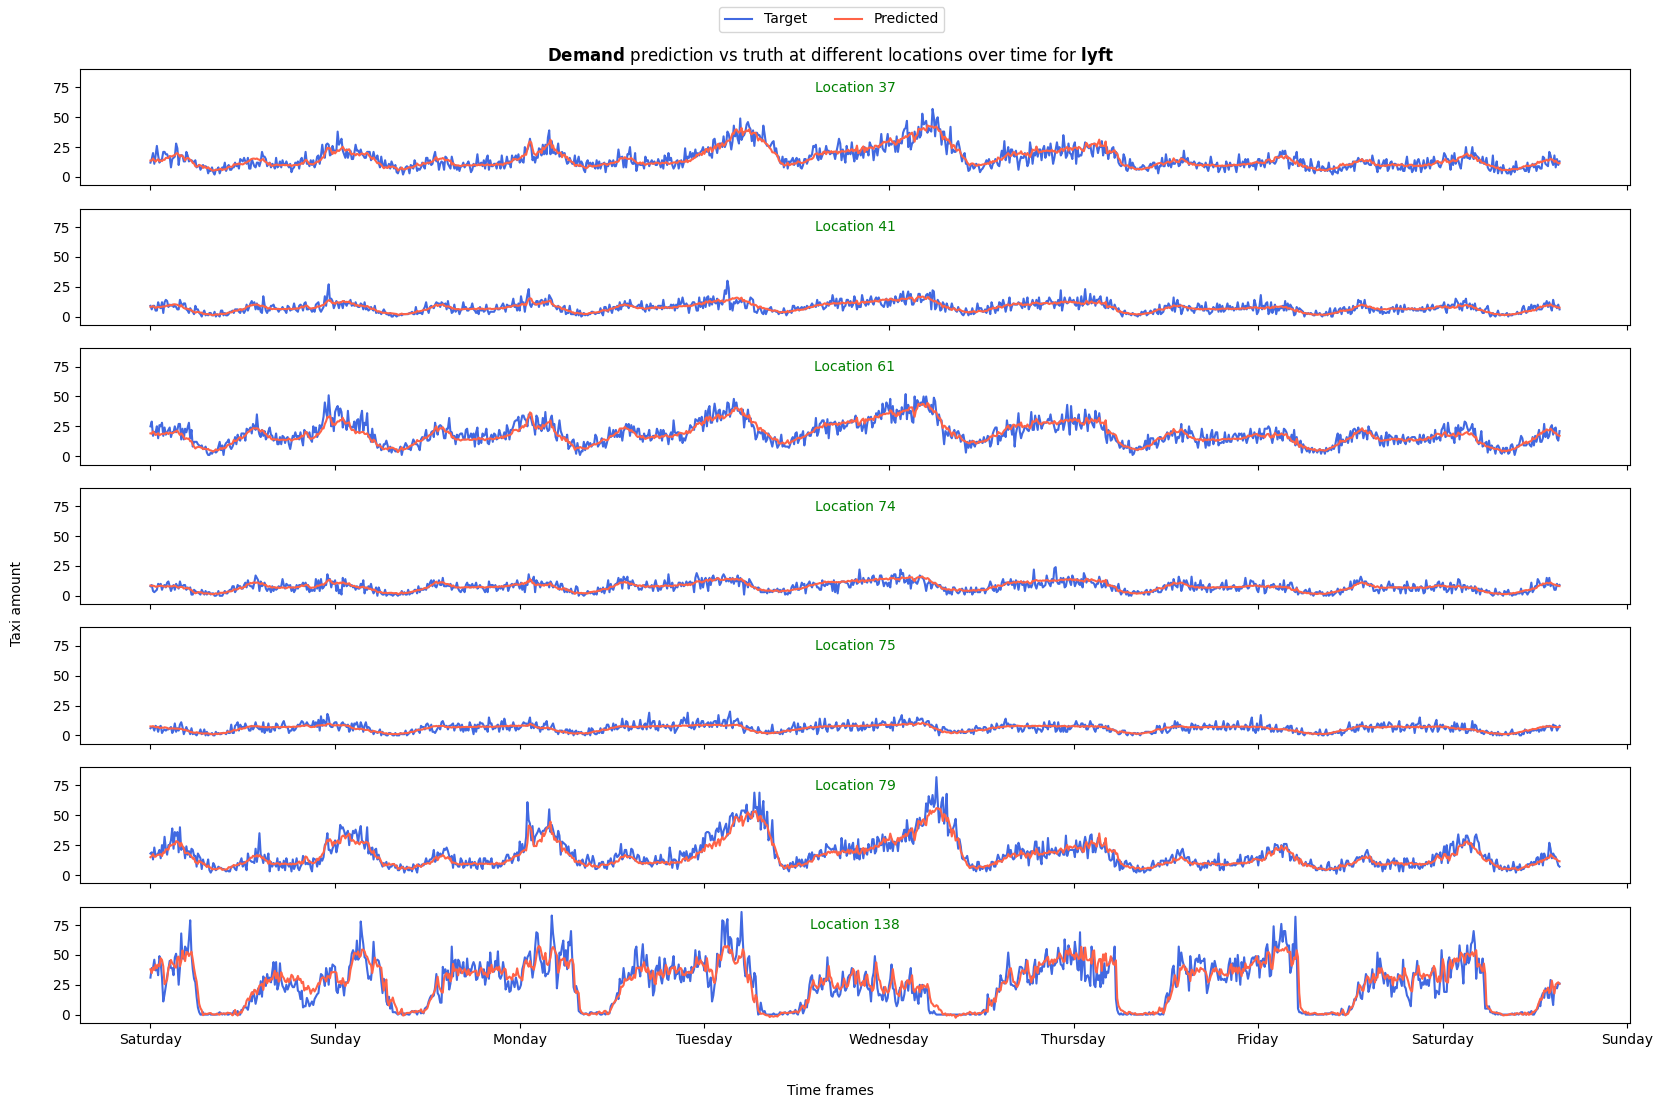

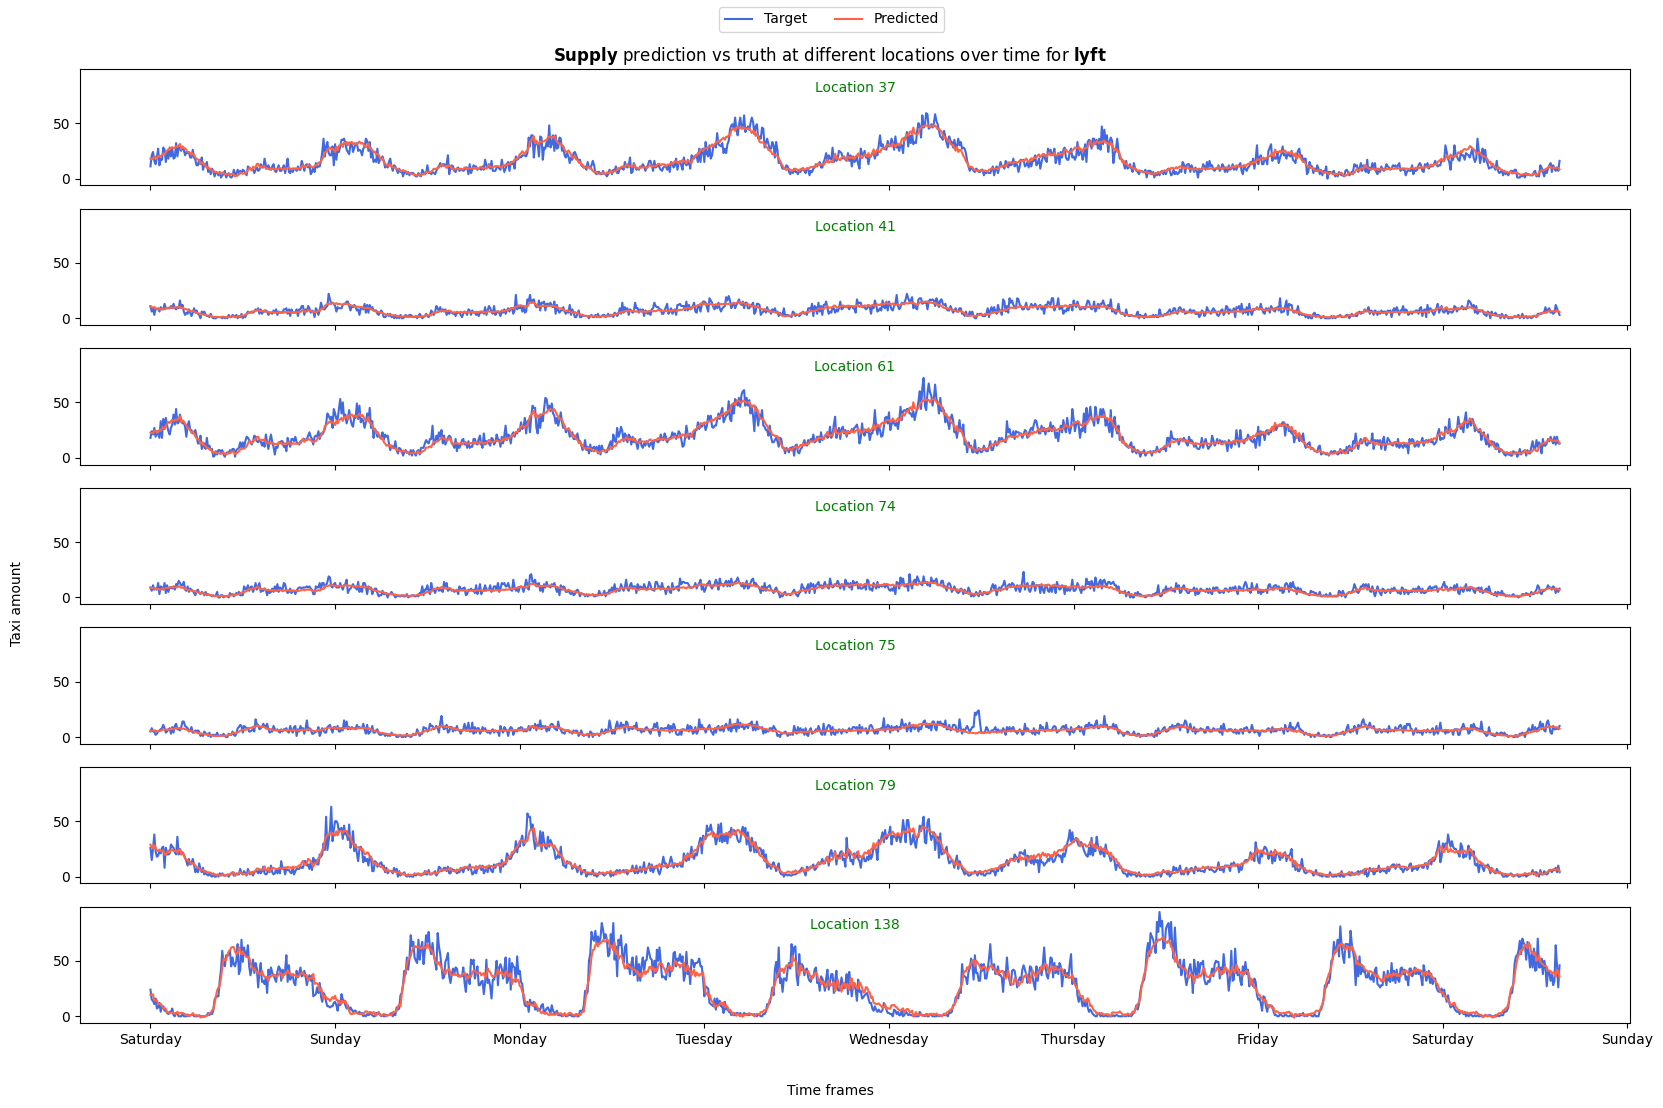

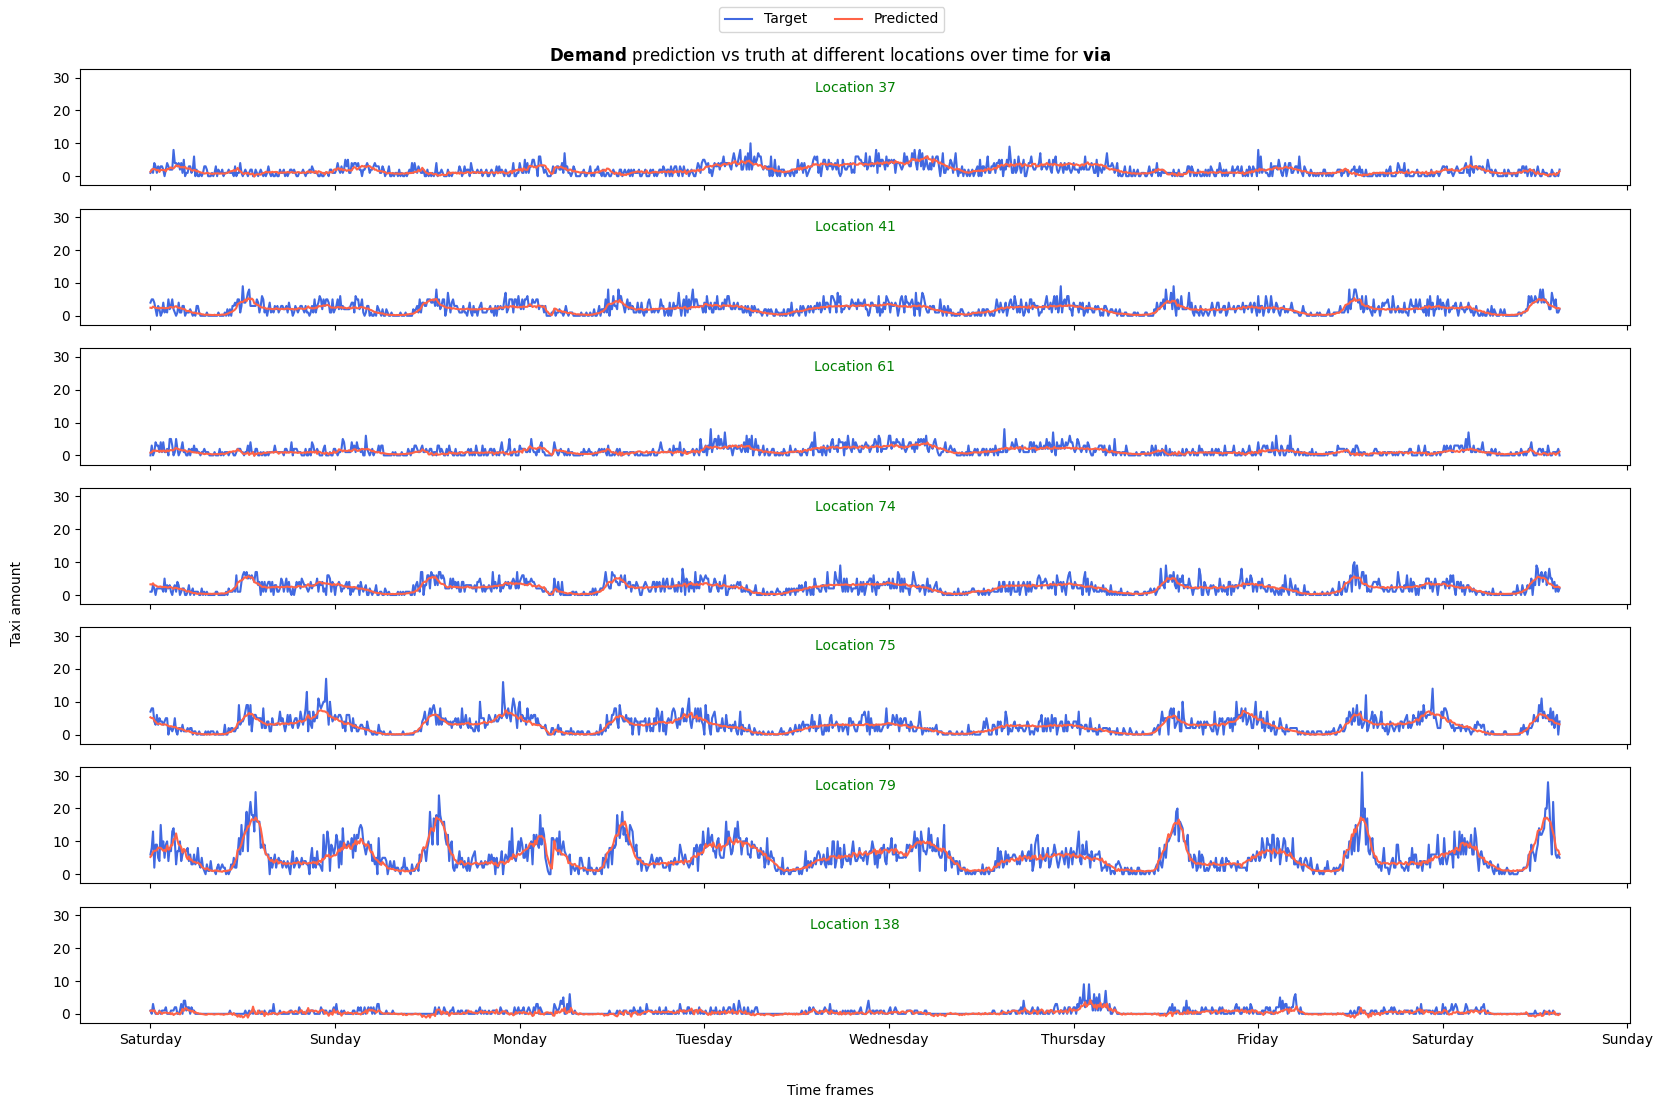

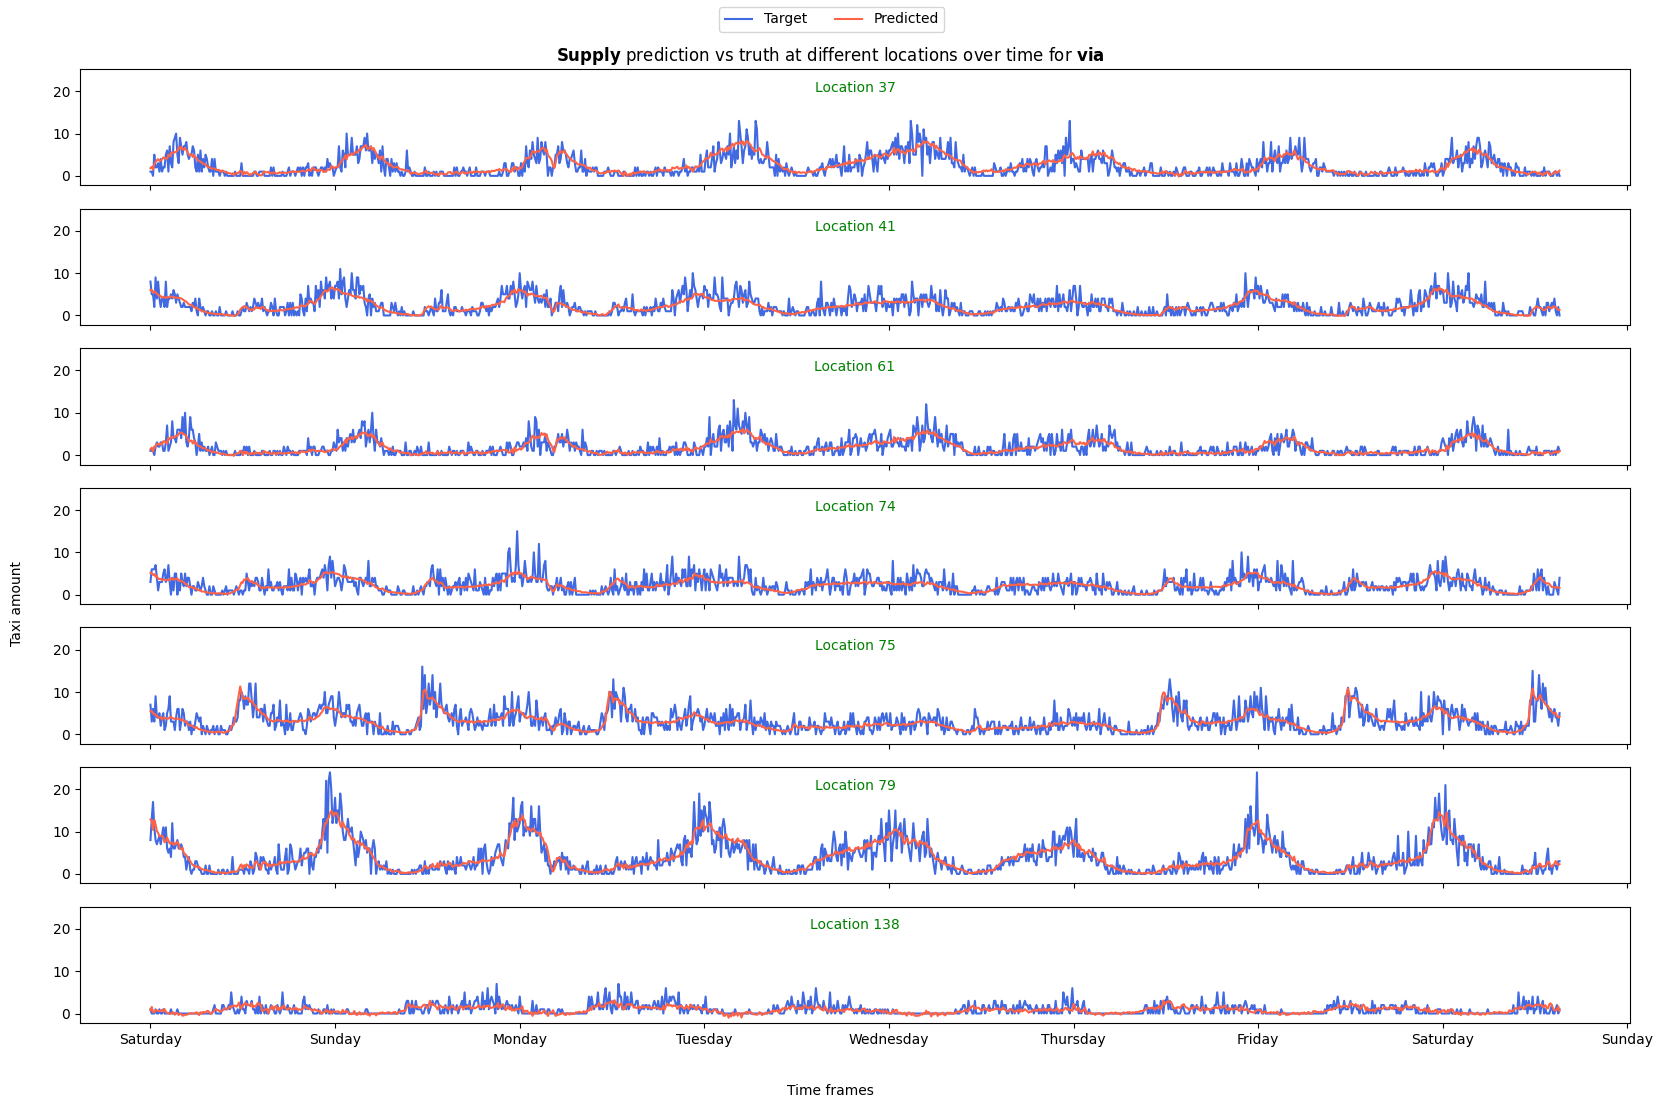

In [ ]:
# plt.style.use('ggplot')
plt.style.use('default')
colNums = [37, 41, 61, 74, 75, 79, 138]
plt.rcParams["date.autoformatter.day"] = "%A"

def plot_pred_true_comparison(taxi_name, feature, true_values, pred_values):
    fig, axs = plt.subplots(len(colNums), sharex=True, sharey=True, figsize=(20, 12))
    fig.subplots_adjust(top=0.945, bottom=0.15) # all subplots topmost at 0.945
    fig.suptitle(r"$\bf{" + feature + r"}$ prediction vs truth at different locations over time for $\bf{"+taxi_name + r"}$", y=0.965)
    for i, column_num in enumerate(colNums):
        # axs[i].plot(timeframe_plot_range, taxi_subset.iloc[1008:2016, column_num], "royalblue", label="Target")
        axs[i].plot(timeframe_plot_range, true_values[:, column_num-1], "royalblue", label="Target")
        axs[i].plot(timeframe_plot_range, pred_values[:, column_num-1], "tomato", label="Predicted")
        # axs[i].set_ylim([0, 300])
        # print location ID at the middle top
        axs[i].text(0.5, 0.9, "Location "+str(column_num),
                    horizontalalignment='center', verticalalignment='top',
                    transform=axs[i].transAxes,
                    color='green')
        '''
        fix the xticks to weekdays manually
        if plt.rcParams["date.autoformatter.day"] has been use
        no need of the following
        '''
        # axs[i].xaxis.set_major_formatter(DateFormatter("%A"))

    fig.text(0.5, 0.09, 'Time frames', ha='center') # colab pyplot default version is 3.2.2, haven't implement figure.supxlabel()
    fig.text(0.09, 0.5, 'Taxi amount', va='center', rotation='vertical') # if 3.4.1, we can use figure.supylabel()
    handles, labels = axs[i].get_legend_handles_labels() # only take one legend
    fig.legend(handles, labels, loc='upper center', ncol = 2)


def load_pred_pickup_dropoff(taxi_name, feature):
    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/"+feature+"_prediction_"+taxi_name+".pkl", "rb") as f:
        (pred_dropoff, true_dropoff) = pickle.load(f)
    return true_dropoff, pred_dropoff


true_dropoff, pred_dropoff = load_pred_pickup_dropoff("uber", "pickup")
timeframe_plot_range = pd.date_range("2021-06-05", "2021-07-12" , freq='10min')[:pred_dropoff.shape[0]]

for taxi_name in taxi_names:
    for title_feature, feature in zip(['Demand', 'Supply'], ['pickup', 'dropoff']):
        true_y, pred_y = load_pred_pickup_dropoff(taxi_name, feature)
        plot_pred_true_comparison(taxi_name, title_feature, true_y, pred_y)
    #     break
    # break

# Modify the output data for Shiny


In [ ]:
def transform_to_shiny_inputs(pred_subset, feature, taxi_name):
    pred_dropoff_uber_pd = pd.DataFrame(pred_subset, index=timeframe_plot_range)
    pred_dropoff_uber_pd.reset_index(inplace=True)
    pred_dropoff_uber_pd.rename(columns={'index': feature+'_datetime'}, inplace=True)
    pred_dropoff_uber_pd = pred_dropoff_uber_pd.melt(id_vars = feature+'_datetime',var_name=feature+'LocationID', value_name='count')
    pred_dropoff_uber_pd['taxi'] = taxi_name
    pred_dropoff_uber_pd[feature+'LocationID'] = pred_dropoff_uber_pd[feature+'LocationID']+1 # fix the indexing shift to original location id
    pred_dropoff_uber_pd[[feature+'LocationID',feature+'_datetime','taxi', 'count']]\
        .to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/Shiny_data/predict_"+ feature +"_"+ taxi_name +"_for_shiny.csv", index = False)


for taxi_name in taxi_names:
    for title_feature, feature in zip(['PU', 'DO'], ['pickup', 'dropoff']):
        true_y, pred_y = load_pred_pickup_dropoff(taxi_name, feature)
        transform_to_shiny_inputs(pred_y, title_feature, taxi_name)